Fitting 5 folds for each of 11 candidates, totalling 55 fits


D:\TU_Wien\Machine_Learning\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
D:\TU_Wien\Machine_Learning\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw



Best Parameters: {'clf__C': 0.1}
Validation Classification Report:
              precision    recall  f1-score   support

     Agresti       1.00      1.00      1.00         3
   Ashbacher       1.00      0.50      0.67         2
       Auken       0.67      1.00      0.80         2
 Blankenship       1.00      1.00      1.00         3
       Brody       1.00      0.33      0.50         3
       Brown       0.00      0.00      0.00         3
    Bukowsky       1.00      1.00      1.00         3
         CFH       0.75      1.00      0.86         3
   Calvinnme       1.00      1.00      1.00         3
     Chachra       1.00      1.00      1.00         4
    Chandler       1.00      0.33      0.50         3
       Chell       0.57      1.00      0.73         4
    Cholette       0.67      0.67      0.67         3
      Comdet       0.57      1.00      0.73         4
        Corn       0.33      0.67      0.44         3
       Cutey       1.00      1.00      1.00         3
    Davisson 

D:\TU_Wien\Machine_Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\TU_Wien\Machine_Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\TU_Wien\Machine_Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


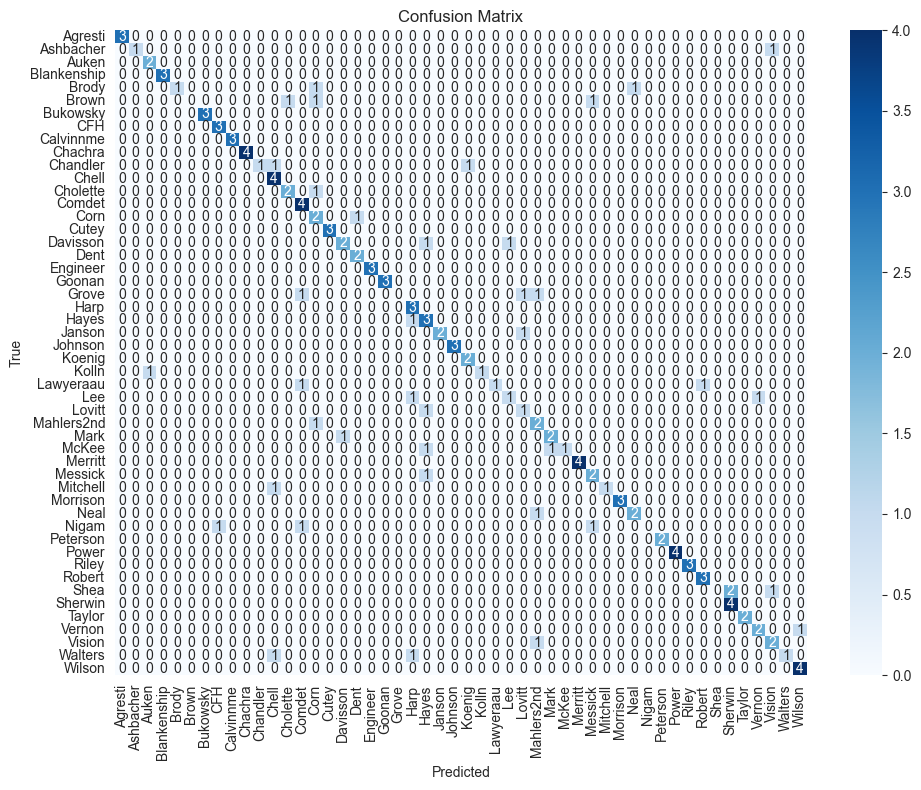

submission saved as 'reviews_submission_v11.csv'


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load and prepare the data
# -------------------------------
train_df = pd.read_csv("all_datasets/amazon_review_ID.shuf.lrn.csv")
test_df = pd.read_csv("all_datasets/amazon_review_ID.shuf.tes.csv")

X_raw = train_df.drop(columns=["ID", "Class"])
y_raw = train_df["Class"]
X_test_raw = test_df.drop(columns=["ID"])
test_ids = test_df["ID"]

# -------------------------------
# 2. Encode class labels
# -------------------------------
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)
class_names = label_encoder.classes_

# -------------------------------
# 3. TF-IDF Transformation
# -------------------------------
tfidf = TfidfTransformer()
X = tfidf.fit_transform(X_raw)
X_test = tfidf.transform(X_test_raw)

# -------------------------------
# 4. Log-Count Ratio Weighting
# -------------------------------
alpha = 1
X_counts = X_raw.values
log_count_ratios = np.zeros(X_counts.shape[1])
n_classes = len(np.unique(y_encoded))

for i in range(n_classes):
    p = X_counts[y_encoded == i].sum(axis=0) + alpha
    q = X_counts[y_encoded != i].sum(axis=0) + alpha
    log_count_ratios += np.log(p / p.sum()) - np.log(q / q.sum())
log_count_ratios /= n_classes

X = X.multiply(log_count_ratios)
X_test = X_test.multiply(log_count_ratios)

# -------------------------------
# 5. Train/Validation Split
# -------------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# -------------------------------
# 6. Build the Pipeline
# -------------------------------
pipeline = Pipeline([
    ("scale", StandardScaler(with_mean=False)),                     # Normalize TF-IDF values
    ("select", SelectKBest(k=7000)),                          # Filter most relevant 7k features
    ("svd", TruncatedSVD(n_components=750, random_state=42)),       # Reduce to 750 latent dimensions
    ("clf", LinearSVC(class_weight='balanced', max_iter=15000, dual=False, random_state=42))
])

# -------------------------------
# 7. Hyperparameter Grid Search
# -------------------------------
param_grid = {
    "clf__C": [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10, 25, 50, 100]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring="f1_macro",       # Macro F1 to account for any class imbalance
    cv=5,
    verbose=3,
    n_jobs=-1
)

grid.fit(X_train, y_train)

# -------------------------------
# 8. Evaluation
# -------------------------------
print("\nBest Parameters:", grid.best_params_)
val_preds = grid.predict(X_val)
print("Validation Classification Report:")
print(classification_report(y_val, val_preds, target_names=class_names))

# Confusion Matrix
conf = confusion_matrix(y_val, val_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# -------------------------------
# 9. Predict on Test Set
# -------------------------------
final_model = grid.best_estimator_
test_preds = final_model.predict(X_test)
test_labels = label_encoder.inverse_transform(test_preds)

# -------------------------------
# 10. Save Kaggle Submission File
# -------------------------------
submission = pd.DataFrame({
    "ID": test_ids,
    "Class": test_labels
})

submission.to_csv("reviews_submission_11_1.csv", index=False)
print("submission saved as 'reviews_submission_v11.csv'")